In [110]:
import os
import re
import pandas as pd
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from matplotlib import pyplot

In [111]:
DATA = "data"
POS = "pos"
NEG = "neg"
ACL_IMDB = "aclImdb"
TRAIN = "train"
TEST = "test"

In [42]:
from nltk.corpus import stopwords

In [99]:
dataset_parts = (TRAIN, TEST)
text_sentiments = (POS, NEG)

filename_parser = re.compile(r"(?P<id>\d+)_(?P<rating>\d{,2}).txt")

train_data_list = []
test_data_list = []

for part in dataset_parts:
    for sentiment in text_sentiments:
        for filename in os.listdir(os.path.join(DATA, ACL_IMDB, part, sentiment)):
            with open(os.path.join(DATA, ACL_IMDB, part, sentiment, filename), "r", encoding="utf-8") as file:
                if part == TRAIN:
                    needed_list = train_data_list
                else:
                    needed_list = test_data_list
                needed_list.append({"text": file.read().strip(),
                                    "sentiment": int(sentiment == POS),
                                    "rating": int(filename_parser.match(filename).group("rating"))})

In [100]:
data_train = pd.DataFrame(train_data_list)
data_test = pd.DataFrame(test_data_list)

In [55]:
stopwords_en = stopwords.words("english")

In [141]:
def tp(y_true, y_pred):
    sum_true = 0
    for true, pred in zip(y_true, y_pred):
        if true and pred:
            sum_true += 1
    return sum_true

def fp(y_true, y_pred):
    sum_fp = 0
    for true, pred in zip(y_true, y_pred):
        if not true and pred:
            sum_fp += 1
    return sum_fp

def tn(y_true, y_pred):
    sum_tn = 0
    for true, pred in zip(y_true, y_pred):
        if not true and not pred:
            sum_tn += 1
    return sum_tn

def fn(y_true, y_pred):
    sum_fn = 0
    for true, pred in zip(y_true, y_pred):
        if true and not pred:
            sum_fn += 1
    return sum_fn

In [142]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

In [157]:
vectorizer = TfidfVectorizer(use_idf=True, min_df=10, max_df=1000, stop_words=stopwords_en)
def evaluate_model(model_class,param_grid):
    grid = GridSearchCV(model_class(), param_grid=param_grid)
    pipeline = Pipeline([("vectorizer", vectorizer),
                         ("grid", grid)])
    pipeline.fit(data_train.text, data_train.sentiment)
    predictions = pipeline.predict(data_test.text)
    probabilities = pipeline.predict_proba(data_test.text)
    current_test_df = pd.DataFrame(data_test.copy())
    current_test_df["probabilities"] = probabilities[:,1]
    print(classification_report(data_test.sentiment, predictions))
    print("SkLearn conf matrix")
    print(confusion_matrix(data_test.sentiment, predictions))
    print("My conf matrix")
    print(f"{tn(data_test.sentiment, predictions)} {fp(data_test.sentiment, predictions)}\n{fn(data_test.sentiment, predictions)} {tp(data_test.sentiment, predictions)}")
    lr_auc = roc_auc_score(data_test.sentiment, predictions)
    lr_fpr, lr_tpr, _ = roc_curve(data_test.sentiment, predictions)
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    pyplot.show()
    print("The least positive reviewes")
    print(current_test_df.nsmallest(15, columns=["probabilities"]))
    print("The most positive reviewes")
    print(current_test_df.nlargest(15, columns=["probabilities"]))

# Logistic Regression

/Users/grigoriyarshinov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


              precision    recall  f1-score   support

           0       0.83      0.85      0.84     12500
           1       0.84      0.82      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

SkLearn conf matrix
[[10581  1919]
 [ 2200 10300]]
My conf matrix
10581 1919
2200 10300


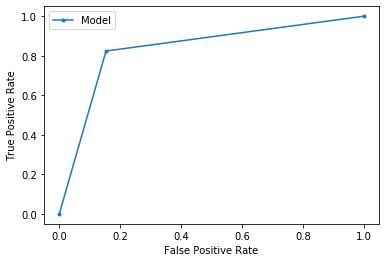

The least positive reviewes
                                                    text  sentiment  rating  \
20333  The worst movie I've ever seen in my life. Fro...          0       3   
16689  Sure it is a new take on vampires. Who cares. ...          0       2   
17036  Bad dialog, slow story, scenes that drag on an...          0       1   
18223  This was a very disappointing movie. I would d...          0       2   
16128  A confusing, senseless script with plot holes ...          0       3   
24977  The horrific production doesn't qualify as a "...          0       1   
15105  I knew it was going to be awful but not this a...          0       1   
18186  I knew it was going to be awful but not this a...          0       1   
24365  Lame is really the best way to describe this m...          0       2   
13039  To me, this movie was just plain confusing, sl...          0       2   
19905  I'm actually too drained to write this review ...          0       1   
22863  Simply put this m

In [158]:
evaluate_model(LogisticRegression, dict(tol=[0.000005], solver=["lbfgs"]))

# SGD Classifier

/Users/grigoriyarshinov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


              precision    recall  f1-score   support

           0       0.81      0.85      0.83     12500
           1       0.84      0.80      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000

SkLearn conf matrix
[[10605  1895]
 [ 2441 10059]]
My conf matrix
10605 1895
2441 10059


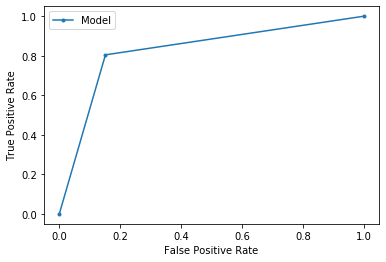

The least positive reviewes
                                                   text  sentiment  rating  \
115   I know it was supposed to be a long walk, but ...          1      10   
129   I cannot understand the need to jump backwards...          1       7   
738   I just wanted to say that. I love Gheorghe Mur...          1      10   
794   I have no idea why everyone hates this movie t...          1      10   
872   The Japanese have probably the most sadistic m...          1       7   
908   This is a totally awesome movie! If you haven'...          1      10   
945   Haggard: The Movie is the real life story of R...          1      10   
999   This is the follow-up creation to Better Off D...          1       7   
1502  This movie will not be considered for an acade...          1       7   
1697  Coming from Oz I probably shouldn't say it but...          1      10   
1838  Okay, this may not be the most sophisticated m...          1       9   
1844  Brain of Blood starts as Abdul

In [159]:
evaluate_model(SGDClassifier, {"loss": ["modified_huber"], "penalty": ["l2", "elasticnet"]})

# Naive Bayes

/Users/grigoriyarshinov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


              precision    recall  f1-score   support

           0       0.78      0.85      0.82     12500
           1       0.84      0.76      0.80     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000

SkLearn conf matrix
[[10678  1822]
 [ 2981  9519]]
My conf matrix
10678 1822
2981 9519


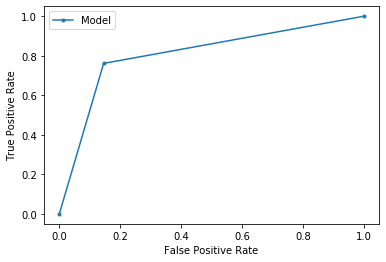

The least positive reviewes
                                                    text  sentiment  rating  \
18175  A movie theater with a bad history of past gru...          0       2   
18809  Oh, where the hell should I begin? Give a brie...          0       1   
24952  Granted, HOTD 2 is better than the Uwe Boll cr...          0       4   
15068  One night on an independent channel famous for...          0       1   
17014  My original comment on this particular title w...          0       1   
17118  I went into this movie hoping for an imaginati...          0       1   
24972  ...the first? Killjoy 1. But here's the review...          0       1   
23091  This movie shows what you can create if you ha...          0       1   
22712  I gotta go with my boy Allen (who also reviewe...          0       1   
23325  Jesus Christ, what the hell happened here?. Th...          0       1   
22955  All I could think while watching this movie wa...          0       1   
24823  But I can't say h

In [160]:
evaluate_model(MultinomialNB, {"alpha": [0.0001, 0.001, 0.01, 1.0]})